### Imports

Get imports from the implicit library

In [1]:
import implicit

import argparse
import codecs
import logging
import time

import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import coo_matrix
from glob import glob
import sys
import os
import pathlib
import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.movielens import get_movielens
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)
from implicit.evaluation import ranking_metrics_at_k, train_test_split

log = logging.getLogger("implicit")

C:\Users\micha\Anaconda3\envs\michael\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\micha\Anaconda3\envs\michael\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\micha\Anaconda3\envs\michael\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


#### Assign output directory

##### Run 'get_coo_from_fractaloutput' function

This method reads the data from the npz files in the directory.

In [2]:
# There are many files numbered from 'trainx4x4_0.npz' to 'trainx4x4_N.npz'

out_dir= (r'C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB')



def get_coo_from_fractaloutput(out_dir, confidence=1.0):
    arrs = {'train': None, 'test': None}
    for kind in ['train', 'test']:
        files = glob(f"{out_dir}/{kind}*.npz")
      #  print('reading files: ', out_dir, files)
        for f in files:
            arr = np.load(f)['arr_0']
            if arrs[kind] is None:
                arrs[kind] = arr
            else:
                arrs[kind] = np.concatenate((arrs[kind], arr))

    mats = {'train': None, 'test': None}
    for kind in ['train', 'test']:
        arr = arrs[kind]
        mats[kind] = coo_matrix( (confidence * np.ones((arr.shape[0])), (arr[:,0], arr[:,1])) )

    print(f"n_users={arrs['train'][:,0].max()+1} n_items={arrs['train'][:,1].max()+1}")
    
    train, test = mats['train'].tocsr(), mats['test'].tocsr()
    sparse.save_npz(f"{out_dir}/mat_train_csr.npz", train)
    sparse.save_npz(f"{out_dir}/mat_test_csr.npz", test)
    return train, test 


#### Run implicit on the data

In [3]:
def evaluate_fractaloutput(out_dir, confidence=1.0, factors=100, regularization=0.01):
    mat_train, mat_test = get_coo_from_fractaloutput(out_dir, confidence=confidence)
    
    model = AlternatingLeastSquares(factors=100, regularization=0.01, num_threads=0)
    model.fit(mat_train.T)
    
    res = ranking_metrics_at_k(model, mat_train, mat_test, K=10, num_threads=0)
    print(f'n_users = {mat_train.shape[0]}, n_items = {mat_train.shape[1]}')
    print(f'results: {res}')
    return model, res

### For loop to read in results from the implicit data

In [4]:
with open("results_100k.csv", "w") as res_f:
    for d in glob(f"{out_dir}/out_*"):
        scale_factor = int(os.path.basename(d).split('_')[1].replace('x', ''))
        print(d, os.path.basename(d), scale_factor)
        model, res = evaluate_fractaloutput(d)
        res_f.write(f"{scale_factor}, {res['precision']}, {res['map']}, {res['ndcg']}, {res['auc']}\n")

C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x16 out_x16 16
n_users=15071 n_items=26912



n_users = 15071, n_items = 26912
results: {'precision': 0.0035392320534223705, 'map': 0.0010835254524736997, 'ndcg': 0.0016450650218070857, 'auc': 0.5015838066418249}
C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x2 out_x2 2
n_users=1886 n_items=3364



n_users = 1886, n_items = 3364
results: {'precision': 0.07628128724672228, 'map': 0.024630843596874587, 'ndcg': 0.03663466261976123, 'auc': 0.536673545265332}
C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x32 out_x32 32
n_users=30176 n_items=53824



n_users = 30176, n_items = 53824
results: {'precision': 0.0013587406793703397, 'map': 0.0004067279493957207, 'ndcg': 0.0006264450381454484, 'auc': 0.5005857737443957}
C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x4 out_x4 4
n_users=3738 n_items=6728



n_users = 3738, n_items = 6728
results: {'precision': 0.019910263600673023, 'map': 0.007300763827684748, 'ndcg': 0.010184011535150297, 'auc': 0.5092078473909016}
C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x64 out_x64 64
n_users=60352 n_items=107648



n_users = 60352, n_items = 107648
results: {'precision': 0.0015078207847295864, 'map': 0.0005153430561867729, 'ndcg': 0.0007433506472266398, 'auc': 0.5006796812329365}
C:\Users\micha\Desktop\Bliain4_Seimeastar2_Desktop\FYP\NB\syth_data_ml-100k_NB\out_x8 out_x8 8
n_users=7540 n_items=13456



n_users = 7540, n_items = 13456
results: {'precision': 0.014090231675924672, 'map': 0.005293245419922021, 'ndcg': 0.007313571226865153, 'auc': 0.5066744846545609}


### Aggregating outputs into a dataframe 

In [42]:
# Convert the results into a dataframe format
import pandas as pd
out_x2 = {'precision': 0.08104886769964244, 'map': 0.026177232911440296, 'ndcg': 0.03881114872889078, 'auc': 0.5390534218063456}
out_x4 = {'precision': 0.019910263600673023, 'map': 0.007357739319320924, 'ndcg': 0.010265106357045844, 'auc': 0.5092087730289292}
out_x8 = {'precision': 0.014361197669692453, 'map': 0.004695614867000857, 'ndcg': 0.006920434589611149, 'auc': 0.5068097056927983}
out_x16 = {'precision': 0.0034724540901502504, 'map': 0.0009672469989665315, 'ndcg': 0.0015413561077070909, 'auc': 0.5015504077289034}
out_x32 = {'precision': 0.001391880695940348, 'map': 0.00038577872463539404, 'ndcg': 0.0006161574417945912, 'auc': 0.5006023363066014}
out_x64 = {'precision': 0.0014581124072110287, 'map': 0.0005120554650810483, 'ndcg': 0.000729978347111302, 'auc': 0.5006548299968578}

s1 = pd.Series(out_x2)
s2 = pd.Series(out_x4)
s3 = pd.Series(out_x8)
s4 = pd.Series(out_x16)
s5 = pd.Series(out_x32)
s6 = pd.Series(out_x64)

data = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
data


KeyboardInterrupt



### Transform dataframe and create graphs for 4 metrics

In [7]:
df = data.transpose()
df.rename(index = {0: "x2", 1:"x4", 2:"x8", 3:"x16", 4:"x32", 5:"x64",}, inplace = True)
df

,precision,map,ndcg,auc
x2,0.081049,0.026177,0.038811,0.539053
x4,0.019910,0.007358,0.010265,0.509209
x8,0.014361,0.004696,0.006920,0.506810
x16,0.003472,0.000967,0.001541,0.501550
x32,0.001392,0.000386,0.000616,0.500602
x64,0.001458,0.000512,0.000730,0.500655


### Precision

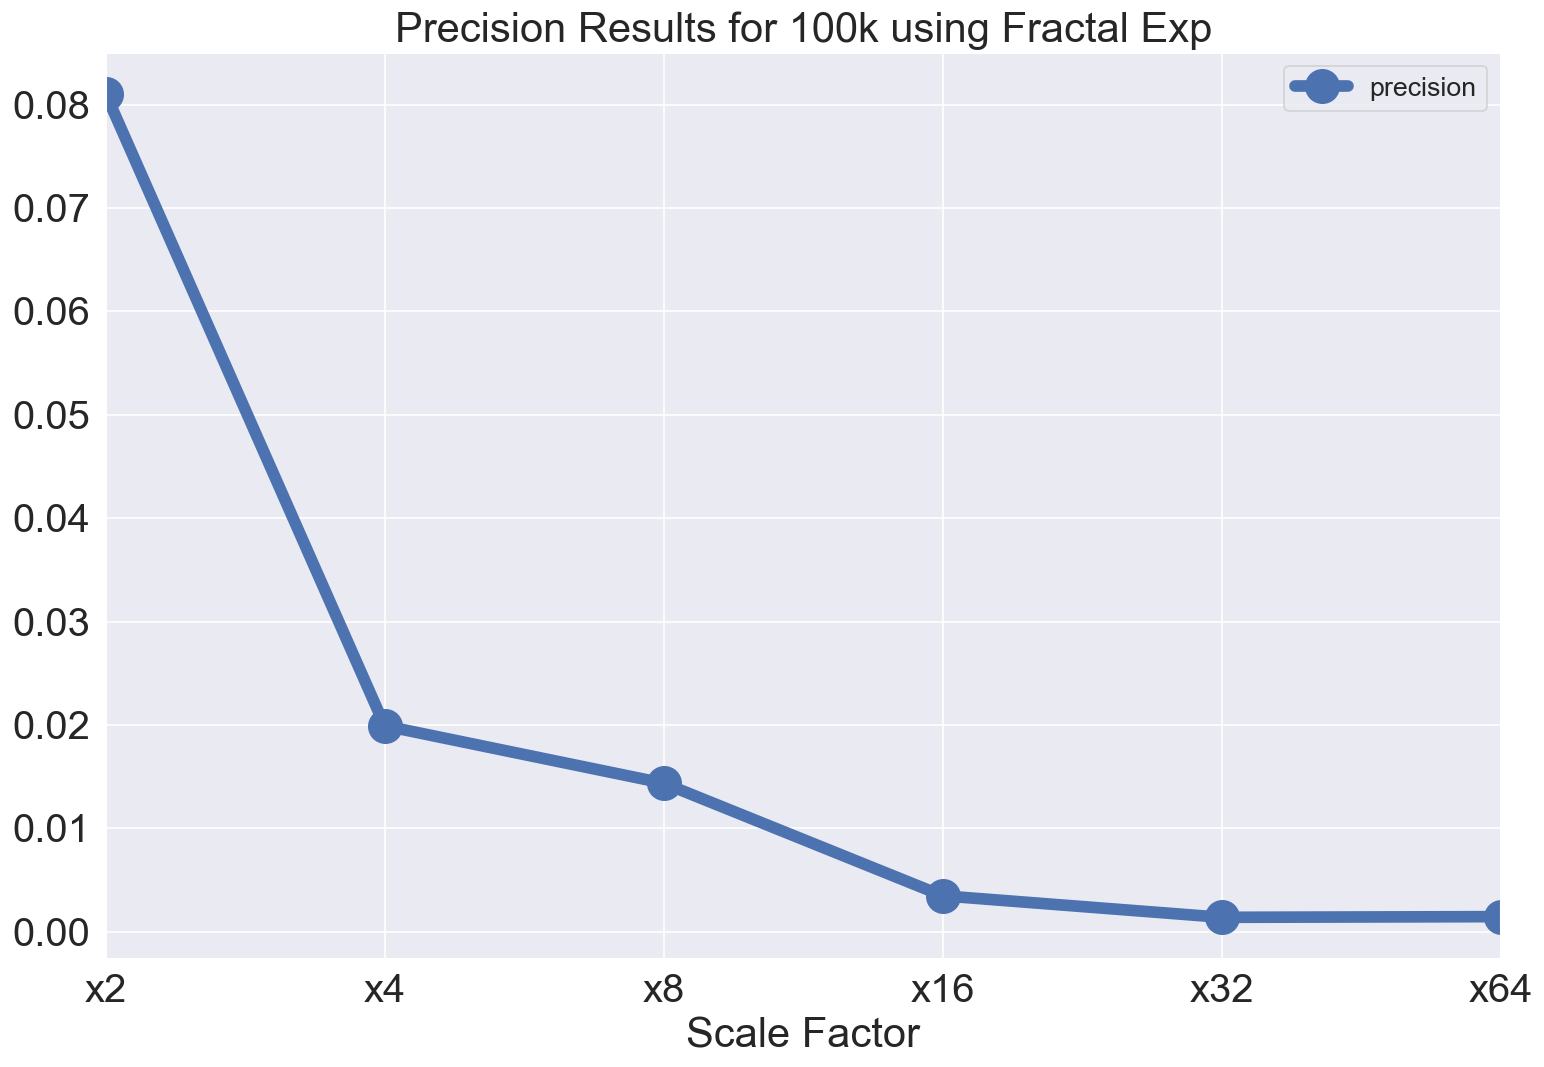

In [63]:
import matplotlib.pyplot as plt
ax = df[['precision']].plot(kind='line', marker = 'o', markersize=20, title = 'Precision Results for 100k using Fractal Exp', figsize=(15, 10), legend=True, fontsize=24, linewidth=7)
ax.title.set_size(25)
ax.set_xlabel("Scale Factor", fontsize=25)
plt.legend(loc=1, prop={'size': 16})
plt.show()




### Map

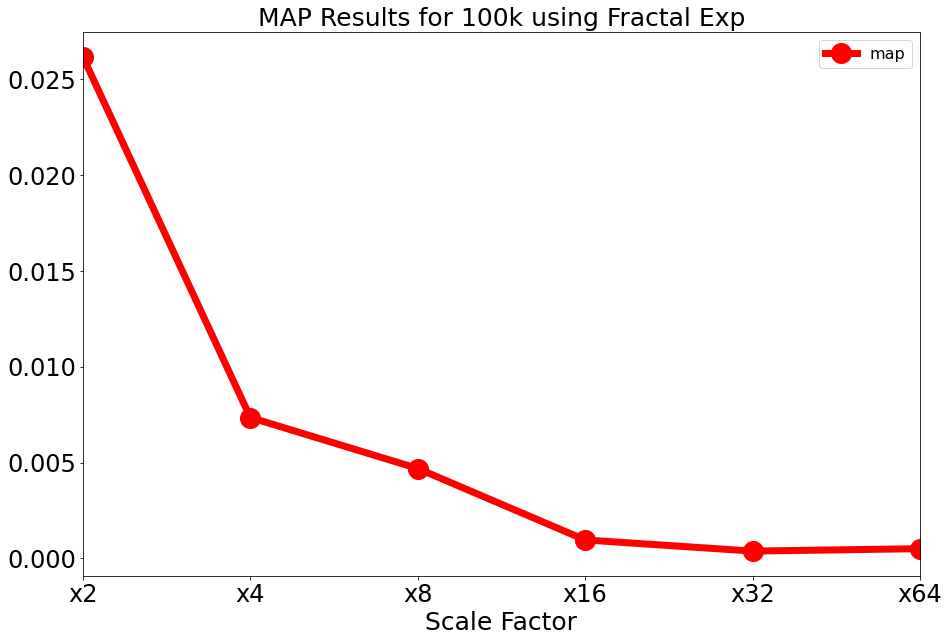

In [56]:
ax = df[['map']].plot(kind='line', color="red", marker = 'o', markersize=20, title ="MAP Results for 100k using Fractal Exp", figsize=(15, 10), legend=True, fontsize=24, linewidth=7)
ax.title.set_size(25)
ax.set_xlabel("Scale Factor", fontsize=25)
plt.legend(loc=1, prop={'size': 16})
plt.show()

### NDCG

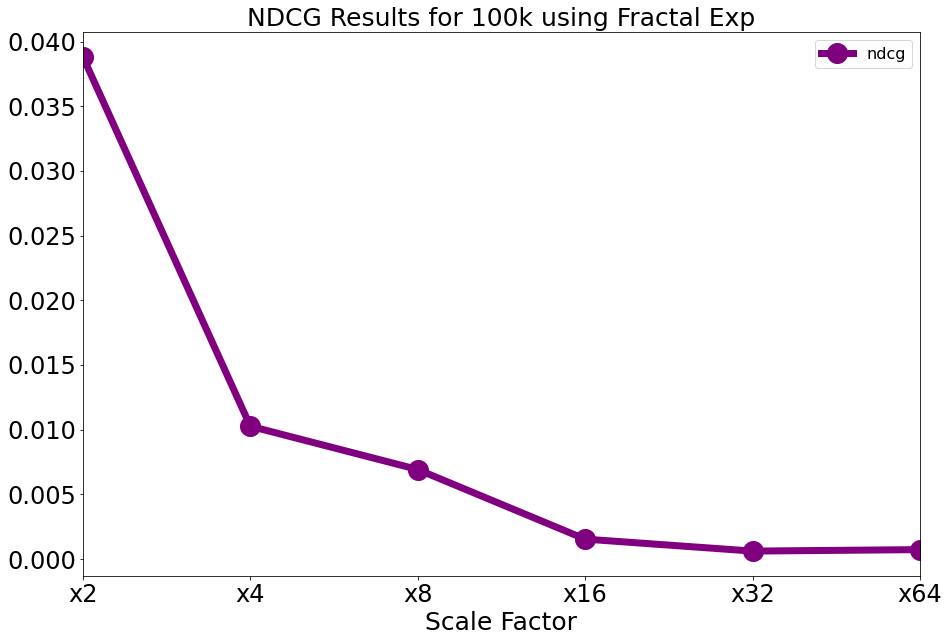

In [57]:
ax = df[['ndcg']].plot(kind='line', color="purple", marker = 'o', markersize=20, title ="NDCG Results for 100k using Fractal Exp", figsize=(15, 10), legend=True, fontsize=24, linewidth=7)
ax.title.set_size(25)
ax.set_xlabel("Scale Factor", fontsize=25)
plt.legend(loc=1, prop={'size': 16})
plt.show()
